In [1]:
from project.models.char_baseline import CharSeqBaseline
from project.models.code2vec_solo import Code2VecSolo
from project.models.code2vec_encoder import Code2VecEncoder
from project.models.base_model import _run_model


/home/ehambro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
load_dir = {"logdir":"logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu", "mode":"RETURN"}
LOADED = _run_model(CharSeqBaseline, **load_dir)


LOADING FROM: logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu, overwriting kwargs


Loading GloVe weights and word to index lookup table


400000it [00:07, 52969.81it/s]


Creating char to index look up table
Tokenizing the word descriptions and characters
Tokenizing the src code
Extracting tensors train and test
INFO:tensorflow:Restoring parameters from logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu/BasicModel.ckpt-8550


0820_18:45 WARNING - Loaded from logs/BIG_X_new_attention_second_experiment__var_otherargs_2008_102707/best_bleu: Global Step 8550


In [4]:
sess, nn, data_tuple, step = LOADED

In [5]:
# RESULTS = nn.evaluate_bleu(sess, data_tuple.test, max_translations=10000)

In [6]:
import random
import numpy as np
from tqdm import tqdm 
from project.external.nmt import bleu


def prep_samples(translations, sample_size, no_samples):
    for n in range(no_samples):
        yield  random.choices(translations, k=sample_size)
        
def get_translations(nn, data):
    return nn.evaluate_bleu(sess, data, max_translations=10000)

def get_bleu_bootstrap(translations, sample_size = 1000, no_samples = 1000):
    bleu_bootstrap = []
    total = []
    for sample in prep_samples(translations, sample_size, no_samples):
        all_references = [[t.description] for t in sample]
        all_translations = [t.translation for t in sample ]
        b = bleu.compute_bleu(all_references, all_translations, max_order=4, smooth=False)
        bleu_bootstrap.append(b[0]*100)
    return bleu_bootstrap
    

In [8]:

just_200 = [ i[:200] for i in data_tuple.test ]
T  = get_translations(nn, just_200)

In [9]:
# bleu_bootstrap = get_bleu_bootstrap(T[-1], sample_size=1000, no_samples=1000)

In [10]:
# print("{:.5f}, {:.5f}".format(np.mean(bleu_bootstrap), np.std(bleu_bootstrap)))

# print("{:.5f}, {:.5f}".format(np.mean(sorted(bleu_bootstrap)[25:-25]), np.std(sorted(bleu_bootstrap)[25:-25])))

In [11]:
# [print(i, t) for i, t in enumerate(T[-1])]

In [12]:
import pickle
from collections import namedtuple

Examples = namedtuple("Examples", ["translations", "data_tuple"])
def find_examples(translations, data_tuple):
    return_index = []
    return_data = [[] for  _ in data_tuple.test]
    for t in translations:
        for i,d in enumerate(data_tuple.test[-1]):
            arg_name = "".join(nn.translate(data_tuple.test[0][i], lookup=nn.idx2char, do_join=False))
            if d == t.description and arg_name == t.name:
                return_index.append(i)
    
    for j in return_index:
        for k, d in enumerate(return_data):
            d.append(data_tuple.test[k][j])
    
    return [np.stack(x) for x in return_data[:-1]] + [return_data[-1]]

def load_examples(name):
    with open("examples/{}.eg.pkl".format(name), 'rb') as f:
         examples = pickle.load(f)
    return examples

def save_examples(name, good_data_tuple):
    with open("examples/{}.eg.pkl".format(name), 'wb') as f:
        pickle.dump(good_data_tuple, f)


### 2 Funcname Otherargs

In [13]:
# good_examples = [T[-1][i] for i in [3,5,13,57, 50, 178]]
# data_examples = find_examples(good_examples, data_tuple)        
# egs = Examples(good_examples,data_examples )
# save_examples("new_attn_otherargs", data_examples)


In [ ]:

# input_egs_idx = []
# for i, r in enumerate(data_tuple.test[0]):

#     if np.array_equal(r[:6], np.array([9, 14, 16, 21, 20, 65])):
#         input_egs_idx.append(i)
# input_egs = []
# for d in data_tuple.test[:-1]:
    
#     input_egs.append(np.stack([d[i] for i in input_egs_idx]))
# input_egs.append([data_tuple.test[-1][i] for i in input_egs_idx])
# # save_examples('input_otherargs', input_egs)

['i', 'n', 'p', 'u', 't', '<SEP-1>', 'n', 'a', 'm', 'e', '<SEP-2>', '<END>']
['a', '`', 'tensor', '`', 'of', 'type', '`', '<UNK>', '`', '.', 'a', '<UNK>', 'tensor', '.', '<END>']
(20, 12)


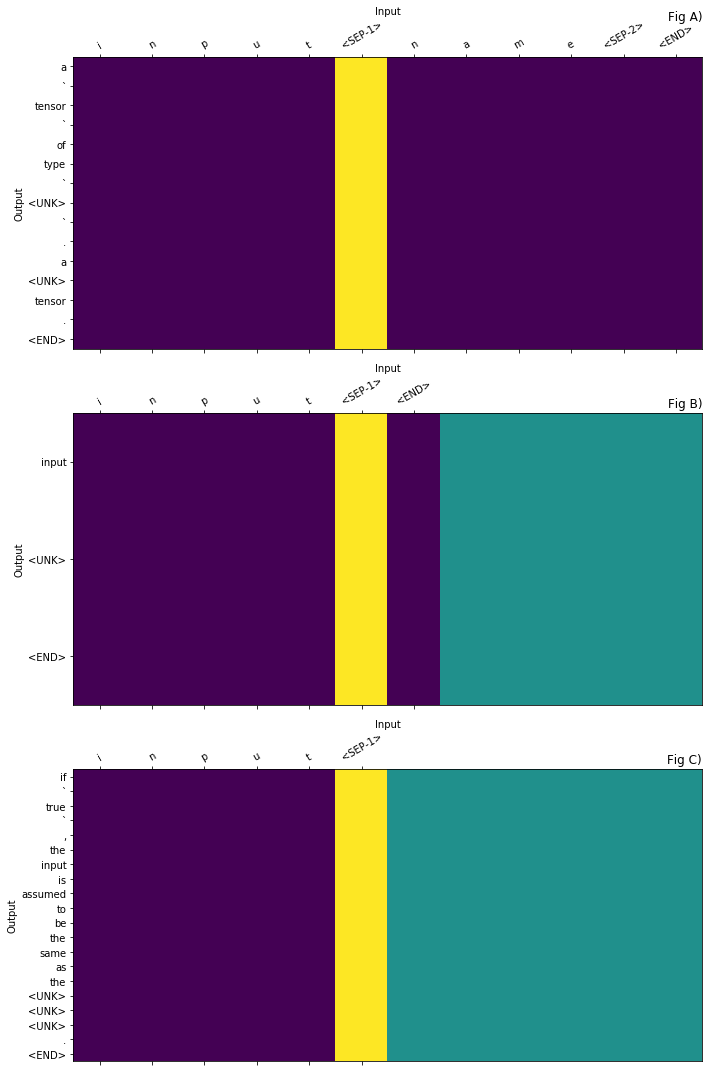

In [16]:

import tensorflow as tf
from matplotlib import pyplot as plt
egs = load_examples('new_attn_otherargs')
j = 4
just_one = [ i[j:j+1] for i in egs ]
trim = len(np.trim_zeros(just_one[0][0]))

alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
word_output = nn.translate(translate[0], do_join=False)
moved = np.squeeze(alignments)
moved = np.stack([i[:trim] for i in moved])

print(char_input)
print(word_output)



fig, ax = plt.subplots(3, figsize=(10,15))
ax[0].set_title("Fig A)\n\n", loc="right")
# plt.rcParams['figure.figsize'] = (10,10)
# plt.rcParams.update({'font.size': 22})
ax[0].matshow(moved, aspect="auto")
ax[0].set_xticks(np.arange(len(char_input)))
ax[0].set_xticklabels( char_input, rotation=30)
ax[0].set_yticks(np.arange(len(word_output)))
ax[0].set_yticklabels(word_output)
ax[0].set_ylabel("Output")
ax[0].set_xlabel("Input")
# ax.xaxis.label.set_fontsize(20)
ax[0].xaxis.set_label_position('top') 


# just_one[0][0][] = nn.char2idx['<SEP-2>']
just_one[0][0][6] = nn.char2idx['<END>']
just_one[0][0][7:] = 0 

trim2 = len(np.trim_zeros(just_one[0][0]))
alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
# char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
word_output = nn.translate(translate[0], do_join=False)
moved = np.squeeze(alignments)
moved = np.stack([i[:trim] for i in moved])
moved[:,trim2:] = 0.5

char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)

ax[1].set_title("Fig B)", loc="right")

ax[1].matshow(moved, aspect="auto")
ax[1].set_xticks(np.arange(len(char_input[:trim2])))
ax[1].set_xticklabels( char_input, rotation=30)
ax[1].set_yticks(np.arange(len(word_output)))
ax[1].set_yticklabels(word_output)
ax[1].set_ylabel("Output")
ax[1].set_xlabel("Input")
ax[1].xaxis.set_label_position('top') 
            


just_one[0][0][6:] = 0 
trim3 = len(np.trim_zeros(just_one[0][0]))



alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
word_output = nn.translate(translate[0], do_join=False)
moved = np.squeeze(alignments)
moved = np.stack([i[:trim] for i in moved])
moved[:,trim3:] = 0.5

ax[2].set_title("Fig C)", loc="right")

ax[2].matshow(moved, aspect="auto")
ax[2].set_xticks(np.arange(len(char_input[:trim3])))
ax[2].set_xticklabels( char_input, rotation=30)
ax[2].set_yticks(np.arange(len(word_output)))
ax[2].set_yticklabels(word_output)
ax[2].set_ylabel("Output")
ax[2].set_xlabel("Input")
ax[2].xaxis.set_label_position('top') 

# plt.yticks(np.arange(len(word_output)), word_output)

# ax.xaxis.label.set_fontsize(20)
print(moved.shape)
plt.tight_layout()
plt.show()


In [ ]:

import tensorflow as tf
from matplotlib import pyplot as plt
egs = load_examples('input_otherargs')
j = 22
just_one = [ i[j:j+1] for i in egs ]
trim = len(np.trim_zeros(just_one[0][0]))

alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
word_output = nn.translate(translate[0], do_join=False)
moved = np.squeeze(alignments)
moved = np.stack([i[:trim] for i in moved])

print(char_input)
print(word_output)



fig, ax = plt.subplots(3, figsize=(10,15))
# plt.rcParams['figure.figsize'] = (10,10)
# plt.rcParams.update({'font.size': 22})
ax[0].matshow(moved, aspect="auto")
ax[0].set_xticks(np.arange(len(char_input)))
ax[0].set_xticklabels( char_input, rotation=30)
ax[0].set_yticks(np.arange(len(word_output)))
ax[0].set_yticklabels(word_output)
ax[0].set_ylabel("Output")
ax[0].set_xlabel("Input")
# ax.xaxis.label.set_fontsize(20)
ax[0].xaxis.set_label_position('top') 


j = 2
just_one = [ i[j:j+1] for i in egs ]
trim = len(np.trim_zeros(just_one[0][0]))

alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
# char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
word_output = nn.translate(translate[0], do_join=False)
moved = np.squeeze(alignments)
moved = np.stack([i[:trim] for i in moved])
moved[:,trim:] = 0.5

char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)

ax[1].matshow(moved, aspect="auto")
ax[1].set_xticks(np.arange(len(char_input[:trim])))
ax[1].set_xticklabels( char_input, rotation=30)
ax[1].set_yticks(np.arange(len(word_output)))
ax[1].set_yticklabels(word_output)
ax[1].set_ylabel("Output")
ax[1].set_xlabel("Input")
ax[1].xaxis.set_label_position('top') 
            


j = 0
just_one = [ i[j:j+1] for i in egs ]
trim = len(np.trim_zeros(just_one[0][0]))

alignments, translate = nn._feed_fwd(sess, just_one, [nn.inf_state.alignment_history.stack(), nn.inference_id] )
char_input = nn.translate(just_one[0][0], lookup=nn.idx2char, do_join=False)
word_output = nn.translate(translate[0], do_join=False)
moved = np.squeeze(alignments)
moved = np.stack([i[:trim] for i in moved])
moved[:,trim:] = 0.5

ax[2].matshow(moved, aspect="auto")
ax[2].set_xticks(np.arange(len(char_input[:trim])))
ax[2].set_xticklabels( char_input, rotation=30)
ax[2].set_yticks(np.arange(len(word_output)))
ax[2].set_yticklabels(word_output)
ax[2].set_ylabel("Output")
ax[2].set_xlabel("Input")
ax[2].xaxis.set_label_position('top') 

            
# plt.yticks(np.arange(len(word_output)), word_output)

# ax.xaxis.label.set_fontsize(20)
print(moved.shape)
plt.tight_layout()
plt.show()


In [ ]:
egs = load_examples('input_otherargs')

T  = get_translations(nn, egs)

In [ ]:
# 10, 12, 23, 83, 192, 213, 237, 240, 247, 263, 
for i, t in enumerate(T[-1]):
    print(i,t)

In [ ]:
char_embeddings = nn.get_scope_variable(sess, 'embed_vars', 'char_embed')

In [ ]:
len(data_tuple.test[-1])


In [ ]:
#"\n".join("\t".join([str(j) for j in i]) for i in char_embeddings[0]) 
print("\n".join(["Char"] + [nn.idx2char[i] for i in sorted(nn.idx2char.keys())]))
